# FinOpt — Simulation & Optimization Demo

This notebook showcases the **current MVP** of FinOpt:

- Income modeling → monthly contributions
- Three-case deterministic scenarios (base/optimistic/pessimistic)
- Monte Carlo simulation (IID lognormal)
- Optimization solvers: minimum contribution (closed-form), minimum time (binary search)
- Goal evaluation & chance-constraints
- (Bonus) Multi-asset portfolio simulation


# 0) Setup

In [14]:
# --- Path setup: add project root so "src" is importable ---
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date

import matplotlib.pyplot as plt

# --- Standard libs ---
import numpy as np
import pandas as pd

from src.goals import Goal, evaluate_goals

# --- FinOpt modules (desde /src) ---
from src.income import FixedIncome, IncomeModel, VariableIncome
from src.investment import simulate_capital, simulate_portfolio
from src.scenario import ScenarioConfig, SimulationEngine, plot_scenario, plot_scenarios
from src.utils import summary_metrics

# IncomeModel –  Seasonality and Contributions

## Configuration

In [15]:
# ---------------------------------------------------------------------------
# Income Simulation Configuration
# ---------------------------------------------------------------------------

from datetime import date

# --- Seasonality pattern for variable income (12 months, Jan–Dec) ---
# Values represent multiplicative factors relative to the base income.
seasonality_variable = [
    0.00,  # Jan
    0.00,  # Feb
    0.00,  # Mar
    1.32,  # Apr
    1.32,  # May
    1.36,  # Jun
    1.24,  # Jul
    1.1,  # Aug
    0.5,  # Sep
    0.9,  # Oct
    1.0,  # Nov
    1.31,  # Dec
]

# --- Annual contribution fractions for fixed income (12 months) ---
# Each value represents the fraction of income to contribute for that month.
monthly_contrib_fixed = [
    0.30,  # Jan
    0.30,  # Feb
    0.30,  # Mar
    0.32,  # Apr
    0.35,  # May
    0.35,  # Jun
    0.33,  # Jul
    0.33,  # Aug
    0.20,  # Sep: reduced contribution (holidays)
    0.30,  # Oct
    0.30,  # Nov
    0.15,  # Dec: reduced contribution (Christmas)
]

## Create IncomeModel instance

In [22]:
# --- Create IncomeModel instance ---
income = IncomeModel(
    fixed=FixedIncome(
        base=1_480_000.0,       # Base monthly salary
        annual_growth=0.05,     # 5% nominal annual growth
        salary_raises={
            date(2026, 4, 1): 400_000,  # Salary Raises 200k in April 2026
            date(2027, 4, 1): 400_000  # Salary Raises 200k in April 2027
        }  
    ),
    variable=VariableIncome(
        base=150_000.0,         # Base variable income (e.g., bonuses, side jobs)
        seasonality=seasonality_variable,
        sigma=0.15,             # 0% monthly Gaussian noise
        floor=0,         # Minimum monthly income
        cap=400_000.0,          # Maximum monthly income
        annual_growth=0.0,      # No annual growth for variable component
    ),
)

# --- Simulation parameters ---
# months = 24
# start = date(2025, 9, 1)  # Start date for projection

# --- Define annual contribution fractions for both income streams ---
income.monthly_contribution = {
    "fixed": monthly_contrib_fixed,  # Fraction of fixed income to contribute
    "variable": [1.0] * 12,          # 100% of variable income each month
}

# --- Compute monthly contributions ---
# Fractions are automatically rotated according to `start` and repeated cyclically.
contributions = income.contributions(months=months, start=start)

# Display first few months
contributions.head()

2025-09-01    352246.955101
2025-10-01    588076.493641
2025-11-01    604186.447516
2025-12-01    383127.961720
2026-01-01    451279.982426
Freq: MS, Name: contribution, dtype: float64

In [23]:
income

IncomeModel(horizon=12 months, total_income=19678240.47, total_fixed=18163414.74, total_variable=1514825.73, mean_total=1639853.37, fixed_share=92.3%, variable_share=7.7%)

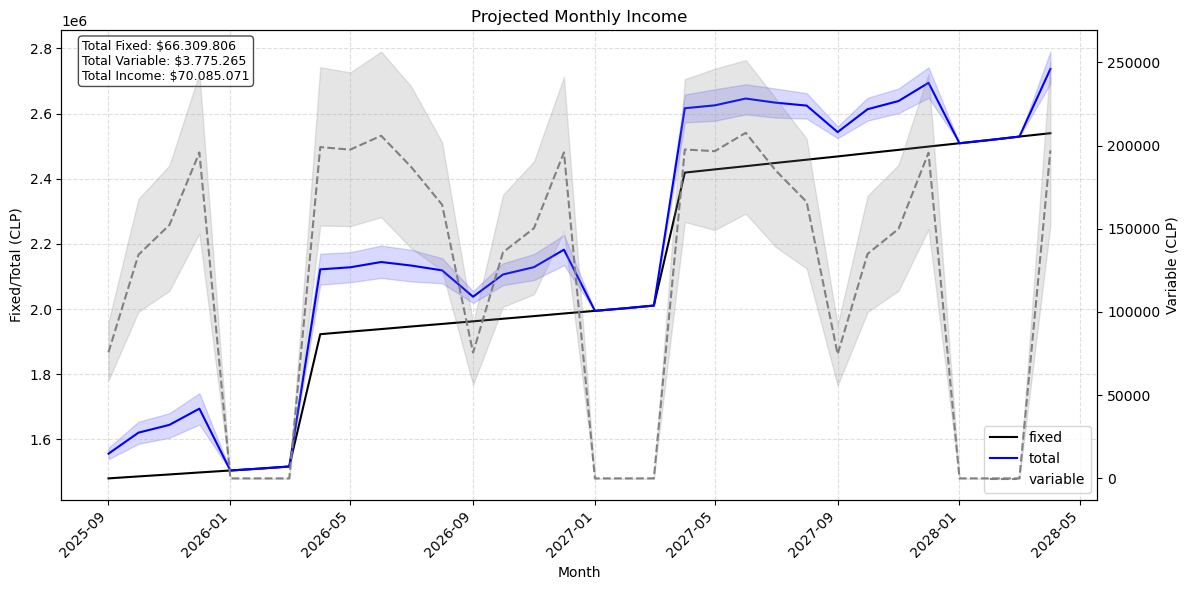

In [27]:
# ==============================
# Income Projection Simulation
# ==============================

from datetime import date

# --- Simulation parameters ---
months = 32
start_date = date(2025, 9, 1)  # Projection start date

# Optional: define custom colors for the plot
plot_colors = {
    "fixed": "black",
    "variable": "gray",
    "total": "blue"
}

# --- Generate and display the projection plot ---
fig, ax = income.plot(
    mode="income",           # Use the wrapper
    months=months,
    start=start_date,
    dual_axis=True,
    title="Projected Monthly Income",
    colors=plot_colors,
    return_fig_ax=True       # Return fig/ax to allow further customization if needed
)

# Optional: adjust layout for better spacing
fig.tight_layout()

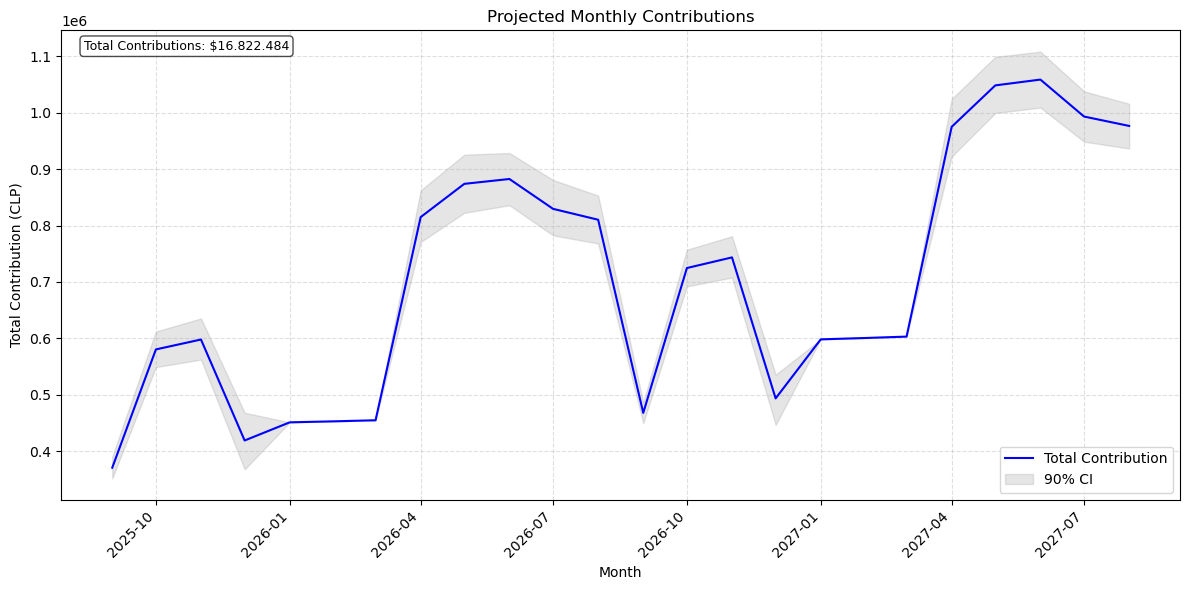

In [29]:
# ==============================
# Contribution Projection Simulation
# ==============================

from datetime import date

# --- Simulation parameters ---
months = 24
start_date = date(2025, 9, 1)  # Projection start date

contrib_colors = {
    "total": "blue",
    "ci": "gray"  # Color de la banda de confianza
}

# --- Generate and display the contributions plot ---
fig, ax = income.plot(
    mode="contributions",    # Llamada al wrapper para contribuciones
    months=months,
    start=start_date,
    title="Projected Monthly Contributions",
    colors=contrib_colors,
    show_confidence_band=True,  # Mostrar banda de confianza
    confidence=0.9,
    n_simulations=500,
    return_fig_ax=True        # Retornar fig/ax para personalización adicional
)

# Optional: adjust layout for better spacing
fig.tight_layout()

In [10]:
# Summary for 24 months
summary_24m = income.summary(months=24, start=date(2025, 9, 1))
print("=== Summary (24 months) ===")
print(summary_24m)

=== Summary (24 months) ===
months                                24.00
total_fixed                     46277575.44
total_variable                   2932787.01
total_income                    49210362.45
mean_fixed                       1928232.31
mean_variable                     122199.46
mean_total                       2050431.77
std_variable                       82006.91
coefvar_variable                       0.67
fixed_share                            0.94
variable_share                         0.06
min_variable                           0.00
max_variable                      225961.73
pct_variable_below_threshold            NaN
dtype: float64


## 2) Build Scenario

In [26]:
# Configuración de escenario (24 meses)
cfg = ScenarioConfig(
    months=24,
    start=date(2025, 9, 1),
    alpha_fixed=0.35,
    beta_variable=1.0,
    base_r=0.004,  # 0.4% mensual
    optimistic_r=0.007,
    pessimistic_r=0.001,
)

sim = SimulationEngine(income, cfg)

results = sim.run_three_cases()

# Mostrar métricas comparativas
summary_metrics(results)

TypeError: IncomeModel.contributions() got an unexpected keyword argument 'alpha_fixed'

In [27]:
from src.scenario import ScenarioConfig, SimulationEngine
from src.utils import fixed_rate_path

cfg = ScenarioConfig(
    months=24, start=date(2025, 9, 1), alpha_fixed=0.35, beta_variable=1.0
)
eng = SimulationEngine(income, cfg, accounts=["housing", "emergency", "free"])

# Ejemplo C(t,k): glidepath lineal
idx = eng._index()
T = len(idx)
w0 = [0.70, 0.20, 0.10]
wT = [0.40, 0.30, 0.30]
glide = np.linspace(0.0, 1.0, T)[:, None]
C = (1 - glide) * np.array(w0) + glide * np.array(wT)

# Retornos por cuenta
r_housing = fixed_rate_path(T, 0.003)
r_emergency = fixed_rate_path(T, 0.001)
r_free = fixed_rate_path(T, 0.006)
R = np.column_stack([r_housing, r_emergency, r_free])

res = eng.run_case_named(
    "glide",
    C_matrix=C,  # (T,K)
    returns_by_account=R,  # (T,K)
)

res.wealth_by_account.tail()
plot_scenario(res)

TypeError: IncomeModel.contributions() got an unexpected keyword argument 'alpha_fixed'

In [28]:
res_base = eng.run_case_named("base", C_matrix=C, returns_by_account=0.004)
res_opt = eng.run_case_named("optimistic", C_matrix=C, returns_by_account=0.007)
res_pes = eng.run_case_named("pessimistic", C_matrix=C, returns_by_account=0.001)

from src.scenario import plot_scenarios

plot_scenarios({"base": res_base, "optimistic": res_opt, "pessimistic": res_pes});

TypeError: IncomeModel.contributions() got an unexpected keyword argument 'alpha_fixed'

## 3) Optimization

In [11]:
from datetime import date
from src.optimization import MinTimeAllocationInput, min_time_with_allocation

# Cuentas y metas
accounts = ["housing", "emergency"]
targets = {"housing": 25_000_000.0, "emergency": 6_000_000.0}

# Input del optimizador (sin months)
inp = MinTimeAllocationInput(
    accounts=accounts,
    targets_by_account=targets,
    start_wealth_by_account=0.0,
    income_model=income,             # ← 
    start=date(2025, 9, 1),          # ← índice mensual base
    alpha_fixed=0.35,
    beta_variable=1.0,
    returns_by_account={"housing": 0.003, "emergency": 0.006},
    T_max=120,
    t_min="auto",
    backend="scipy",                 # o "greedy"
)

res = min_time_with_allocation(inp)
print("Feasible:", res.feasible)
print("T*:", res.T_star)
display(res.C_star.head())
display(res.A_df.head())
display(res.wealth_by_account.head())

TypeError: IncomeModel.contributions() got an unexpected keyword argument 'alpha_fixed'

In [12]:
res.wealth_by_account

NameError: name 'res' is not defined

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Asume que ya corriste:
# res = min_time_with_allocation(inp)

A_df = res.A_df.copy()                 # pesos asignados por cuenta (T×K)
C_df = res.C_star.copy()               # matriz de porcentajes (T×K)
W_df = res.wealth_by_account.copy()    # riqueza por cuenta (+ "total")
a = res.contributions_total.copy()     # contribuciones totales a_t (T,)

accounts = list(C_df.columns)
idx = A_df.index

print("T* =", res.T_star, "| feasible:", res.feasible)
display(C_df.head())
display(A_df.head())
display(W_df.head())


NameError: name 'res' is not defined

NameError: name 'W_df' is not defined

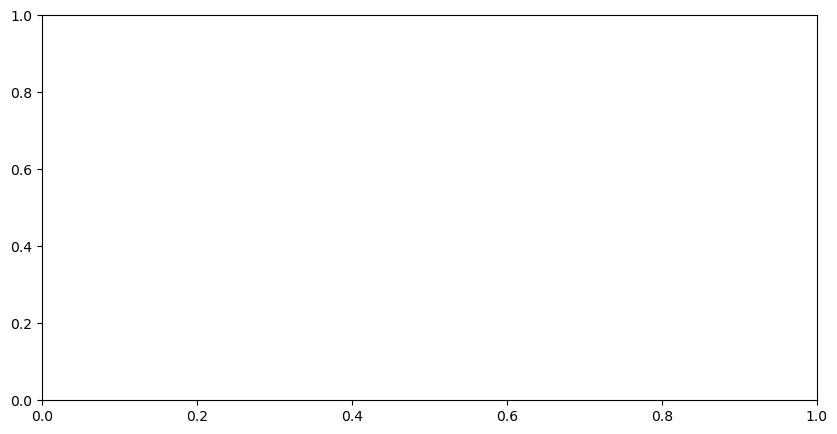

In [14]:
# Formato CLP en millones
millions_fmt = mticker.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M")

fig, ax = plt.subplots(figsize=(10, 5))
for acc in accounts:
    W_df[acc].plot(ax=ax, lw=1.8, label=f"Wealth: {acc}")
if "total" in W_df.columns:
    W_df["total"].plot(ax=ax, lw=2.6, linestyle="--", label="Wealth: total")

ax.set_title(f"Wealth trajectories — min-time solution (T*={res.T_star})")
ax.set_ylabel("Wealth (Million CLP)")
ax.yaxis.set_major_formatter(millions_fmt)
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(ncols=2)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


NameError: name 'a' is not defined

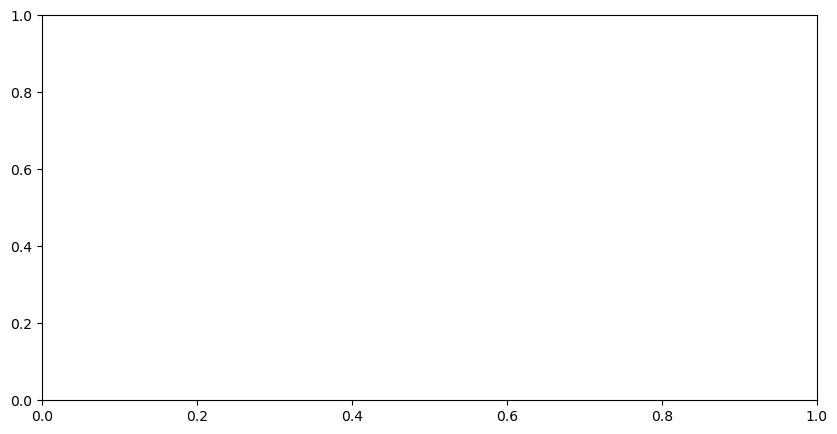

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

# Barras: contribución total a_t
ax.bar(a.index, a.values, alpha=0.25, label="Total monthly contribution a_t")

# Líneas: por cuenta
for acc in accounts:
    A_df[acc].plot(ax=ax, lw=1.6, label=f"Contribution: {acc}")

ax.set_title("Monthly contributions — optimal allocation")
ax.set_ylabel("CLP")
ax.grid(True, linestyle="--", alpha=0.35)
ax.legend(ncols=2)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


NameError: name 'C_df' is not defined

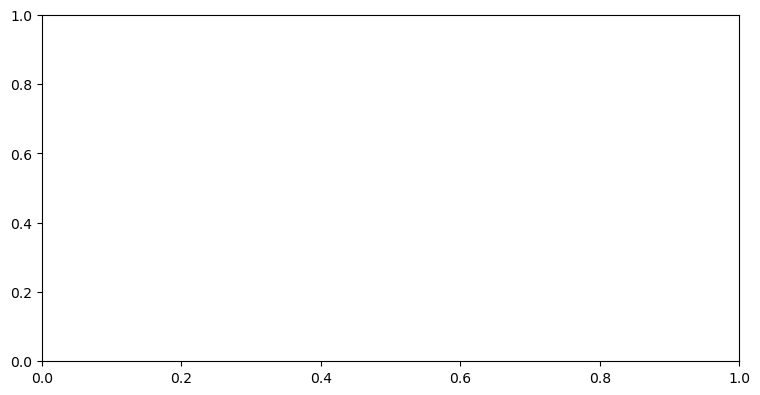

In [16]:
fig, ax = plt.subplots(figsize=(9, 4.5))
im = ax.imshow(C_df.values, aspect="auto", origin="upper")
ax.set_title("Allocation matrix C[t,k] (row-stochastic)")
ax.set_xlabel("Accounts")
ax.set_ylabel("Time (months)")

ax.set_xticks(range(len(accounts)))
ax.set_xticklabels(accounts, rotation=0)
# ticks de tiempo cada ~max(T/10,1) pasos
T = len(C_df)
step = max(T // 10, 1)
ax.set_yticks(range(0, T, step))
ax.set_yticklabels([idx[i].strftime("%Y-%m") for i in range(0, T, step)])

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Share of a_t allocated to k")

plt.tight_layout()
plt.show()


In [17]:
eps = 1e-6

# (i) Sumas por fila: x_{t,k} deben sumar a a_t
row_diff = (A_df.sum(axis=1) - a).abs().max()
print(f"Max row-sum |A_df.sum - a|: {row_diff:.6f}  (OK ≤ {1e-6})")

# (ii) Sumas por fila en C: deben sumar ≈ 1 cuando a_t > 0
mask_pos = a > 0
row_diff_C = (C_df[mask_pos].sum(axis=1) - 1.0).abs().max() if mask_pos.any() else 0.0
print(f"Max row-sum |C_df.sum - 1| (where a_t>0): {row_diff_C:.6f}")

# (iii) Verificación de metas alcanzadas en T* (si es factible)
if res.feasible:
    print("\nTargets vs final wealth:")
    for acc in accounts:
        target = float(inp.targets_by_account[acc])
        final_w = float(W_df[acc].iloc[-1])
        margin = final_w - target
        print(f"  - {acc:>12s}: W_T={final_w:,.0f}  target={target:,.0f}  margin={margin:,.0f}")
else:
    print("\nNo feasible solution within T_max; showing last greedy allocation diagnostics:")
    for acc in accounts:
        target = float(inp.targets_by_account[acc])
        final_w = float(W_df[acc].iloc[-1])
        shortfall = target - final_w
        print(f"  - {acc:>12s}: W_T={final_w:,.0f}  target={target:,.0f}  shortfall={shortfall:,.0f}")

# (iv) t_hit por cuenta (primer mes que alcanza la meta)
print("\nFirst hit month index per account (−1 si no alcanza):")
display(res.t_hit_by_account)


NameError: name 'A_df' is not defined